# **<span style="color:lightgreen;">Scaling, Imputing and Heatmaps with Supervised Learning</span>**

## **Purpose of Notebook**


- Load datasets
- Sample to balance size
- Dummy fill NaNs
- Encode categoricals
- Scale numericals
- Supervised imputation
- Correlation heatmap
- Feature selection (top 10)

---

**Load needed Libraries**

In [82]:
# Basic Libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Preprocessing Libaries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# Model Libaries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Evaluation Libaries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

**Load in the cleaned datasets**

In [45]:
# Display all columns of a pandas DataFrame when printed
pd.set_option('display.max_columns', None)

# US Dataset
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US-cleaned_data.csv')


# UK Dataset
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')

print("US Dataset Shape:", US_data.shape)
print("UK Dataset Shape:", UK_data.shape)

US Dataset Shape: (4372, 21)
UK Dataset Shape: (232365, 21)


In [46]:
# Identify numerical and categorical columns
numerical_columns = ['Posted Speed Limit (MPH)']
catergorical_columns = [
    'Make', 'Model', 'Model Year', 'ADS Equipped?',
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Roadway Surface', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 'Country'
]
datetime_columns = ['Incident Date', 'Incident Time (24:00)']
indexing_columns = ['Report ID', 'Report Version']

**Fill in Missing Data**



In [47]:
from prettytable import PrettyTable

# Function to calculate and display missing values
def display_missing_values(dataset, dataset_name):
    features_with_na = [feature for feature in dataset.columns if dataset[feature].isnull().sum() > 0]
    
    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Feature", "Percentage of Missing Values"]
    
    for feature in features_with_na:
        missing_percentage = np.round(dataset[feature].isnull().mean() * 100, 2)
        table.add_row([feature, f"{missing_percentage} %"])
    
    print(f"Missing Values in {dataset_name}:")
    print(table)

# Check missing values for both datasets
display_missing_values(UK_data, "UK Dataset")
display_missing_values(US_data, "US Dataset")


Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
|  Model  |            1.11 %            |
+---------+------------------------------+
Missing Values in US Dataset:
+--------------------------+------------------------------+
|         Feature          | Percentage of Missing Values |
+--------------------------+------------------------------+
|        Model Year        |            0.32 %            |
|      Incident Date       |            0.43 %            |
|  Incident Time (24:00)   |            4.6 %             |
| Posted Speed Limit (MPH) |           11.34 %            |
+--------------------------+------------------------------+


**Fill in dummy data**

In [48]:
# Fill missing values in 'Model' column with string 'Unknown'
UK_data['Model'].fillna('Unknown', inplace=True)

# Fill missing datetime with a dummy value, e.g., January 1, 1900
dummy_date = pd.to_datetime('1900-01-01')
US_data['Incident Date'].fillna(dummy_date, inplace=True)

# For time column as string, fill missing with dummy time "00:00"
US_data['Incident Time (24:00)'].fillna('00:00', inplace=True)

# Fill missing values in 'Model Year' column with -1 (assuming numerical)
US_data['Model Year'].fillna('Unknown', inplace=True)

# Fill missing values in 'Model Year' column with -1 (assuming numerical)
US_data['Posted Speed Limit (MPH)'].fillna(-1, inplace=True)

# Check missing values for both datasets
display_missing_values(UK_data, "UK Dataset")
display_missing_values(US_data, "US Dataset")



Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
+---------+------------------------------+
Missing Values in US Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
+---------+------------------------------+


/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_4526/2027493121.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  UK_data['Model'].fillna('Unknown', inplace=True)
/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_4526/2027493121.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

**Encode Catergorical and Scale Numerical**

In [59]:
# STEP 1: Make a copy
data_copy = US_data.copy()

# STEP 2: Drop index and datetime columns
data_copy.drop(columns=indexing_columns, inplace=True)
data_copy.drop(columns=datetime_columns, inplace=True)

# STEP 3: Encode all categorical columns
label_encoders = {}
for col in catergorical_columns:
    if col in data_copy.columns:
        le = LabelEncoder()
        data_copy[col] = le.fit_transform(data_copy[col].astype(str))
        label_encoders[col] = le

# STEP 4: Scale numerical columns
scaler = MinMaxScaler()
for col in numerical_columns:
    if col in data_copy.columns:
        data_copy[col] = scaler.fit_transform(data_copy[[col]])


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_copy_scaled = data_copy.copy()
data_copy_scaled[data_copy.columns] = scaler.fit_transform(data_copy)
print(data_copy_scaled.head())



       Make     Model  Model Year  ADS Equipped?  Automation System Engaged?  \
0  0.397059  0.493151    0.615385            0.0                         1.0   
1  0.397059  0.493151    0.615385            1.0                         1.0   
2  0.397059  0.502283    0.538462            1.0                         1.0   
3  0.397059  0.493151    0.615385            0.0                         0.0   
4  0.397059  0.502283    0.615385            0.0                         1.0   

       City     State  Roadway Type  Roadway Surface  \
0  0.518072  0.725490      0.571429              0.0   
1  0.518781  0.725490      0.571429              0.0   
2  0.907867  0.039216      0.000000              0.0   
3  0.555634  0.372549      0.000000              0.0   
4  0.593905  0.901961      0.000000              0.0   

   Posted Speed Limit (MPH)  Lighting  Crash With  \
0                  0.320988  0.166667    0.533333   
1                  0.320988  0.166667    0.533333   
2                  0.81

# **Unsupervised Learning imputing**

**Imputing**

In [67]:
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Use your encoded & scaled dataframe copy
data_for_impute = data_copy_scaled
# Convert dataframe to numpy array for imputer
data_array = data_for_impute.values

### **KNN Imputer**

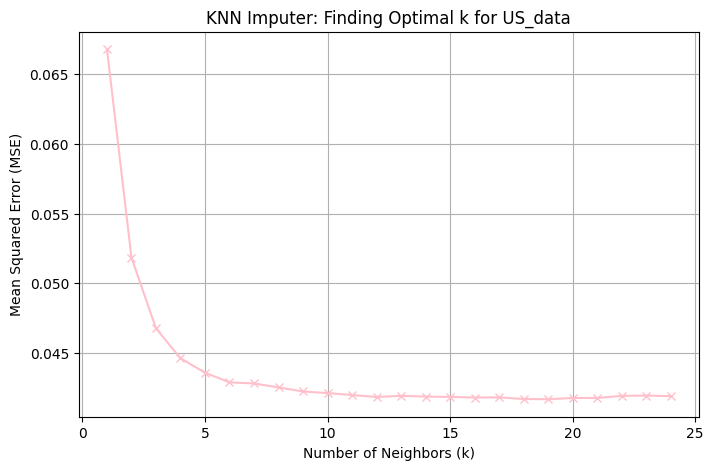

Best k: 19 with MSE: 0.0417


In [70]:
def evaluate_knn_imputer(data, k_values, mask_fraction=0.1, random_state=42):
    np.random.seed(random_state)
    errors = []
    
    # Make a copy of data with no missing values to compare against
    data_no_missing = data.copy()
    
    # Create mask to randomly hide some known values as missing
    mask = np.random.rand(*data.shape) < mask_fraction
    
    # Mask the values in data
    data_masked = data_no_missing.copy()
    data_masked[mask] = np.nan
    
    for k in k_values:
        imputer = KNNImputer(n_neighbors=k)
        imputed_data = imputer.fit_transform(data_masked)
        
        # Calculate MSE only on the artificially masked elements
        mse = mean_squared_error(data_no_missing[mask], imputed_data[mask])
        errors.append(mse) 
    return errors

# Range of k values to test
k_values = range(1, 25)

errors = evaluate_knn_imputer(data_array, k_values)

# Plot the MSE against k to visualize best k choice
plt.figure(figsize=(8,5))
plt.plot(k_values, errors, marker='x',color='pink')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('KNN Imputer: Finding Optimal k for US_data')
plt.grid(True)
plt.show()

# Print best result
# Find best k
best_k = k_values[np.argmin(errors)]
best_error = min(errors)
print(f'Best k: {best_k} with MSE: {best_error:.4f}')

### **K Means Imputer**

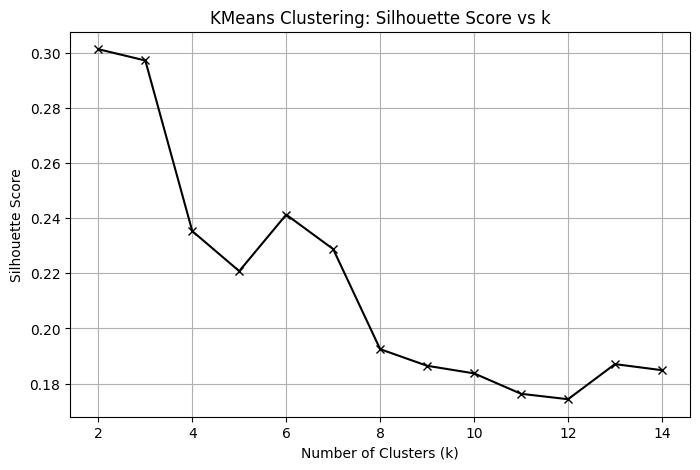

Best k by silhouette score: 2 with score: 0.3012


In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def evaluate_kmeans_silhouette(data, k_values):
    scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        scores.append(score)
    return scores

k_values = range(2, 15)  # silhouette score needs at least 2 clusters
sil_scores = evaluate_kmeans_silhouette(data_array, k_values)

plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, marker='x', color='black', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('KMeans Clustering: Silhouette Score vs k')
plt.grid(True)
plt.show()

best_k = k_values[sil_scores.index(max(sil_scores))]
print(f'Best k by silhouette score: {best_k} with score: {max(sil_scores):.4f}')




### **Mode Imputer**

### **SVM Imputer**

### **Decision Tree Imputer**

### **KNN Imputer**

In [ ]:
### **KNN Imputer**

**Final Imputation**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

def evaluate_knn_imputer(data, k_values, mask_fraction=0.1, random_state=42):
    np.random.seed(random_state)
    errors = []
    
    # Make a copy of the original complete data
    data_no_missing = data.copy()
    
    # Create a mask to simulate missing values
    mask = np.random.rand(*data.shape) < mask_fraction
    data_masked = data_no_missing.copy()
    data_masked[mask] = np.nan
    
    # Evaluate each k
    for k in k_values:
        imputer = KNNImputer(n_neighbors=k)
        imputed_data = imputer.fit_transform(data_masked)
        mse = mean_squared_error(data_no_missing[mask], imputed_data[mask])
        errors.append(mse)
    
    return errors

# Prepare your data array (should contain only numerical values, no actual NaNs yet)
# Example: data_array = your_processed_dataframe.to_numpy()
# Make sure data_array has no missing values before masking
data_array = data.dropna().to_numpy()  # Replace 'data' with your actual DataFrame

# Define range of k to test
k_values = range(1, 25)

# Run evaluation
errors = evaluate_knn_imputer(data_array, k_values)



# Plot results
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, color='pink', marker='x', markeredgecolor='black', markersize=8)
plt.scatter(best_k, best_error, color='black', marker='x', s=100, label=f'Best k = {best_k}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('KNN Imputer: Finding Optimal k for US_data')
plt.grid(True)
plt.legend()
plt.show()

# Print best result
print(f'Best k: {best_k} with MSE: {best_error:.4f}')


**Sample Datasets**

In [52]:
# Downsample the large dataset
UK_data = UK_data.sample(n=4000, random_state=42)
UK_data.shape

(4000, 21)

**Create Heatmap**

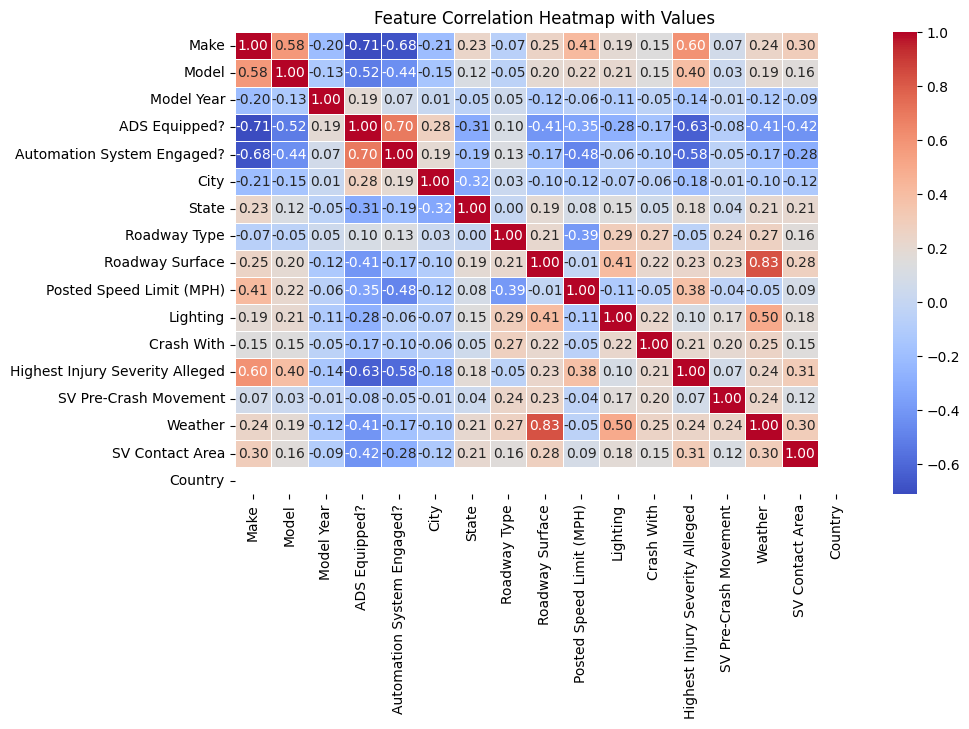

Top 10 most correlated features with 'Highest Severity Injury Alleged':
ADS Equipped?                 0.630859
Make                          0.599922
Automation System Engaged?    0.584365
Model                         0.396102
Posted Speed Limit (MPH)      0.379831
SV Contact Area               0.306161
Weather                       0.242493
Roadway Surface               0.228121
Crash With                    0.213035
City                          0.184581
Name: Highest Injury Severity Alleged, dtype: float64
Filtered dataset shape: (4372, 10)


In [53]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# STEP 5: Now you can compute correlation safely
correlations = data_copy.corr()['Highest Injury Severity Alleged'].abs().dropna().sort_values(ascending=False)


# Plot heatmap with correlation values
plt.figure(figsize=(10, 6))
sns.heatmap(data_copy.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap with Values")
plt.show()


# STEP 6: Top 10 most correlated (excluding the target itself)
most_correlated_features = correlations.iloc[1:11]
print("Top 10 most correlated features with 'Highest Severity Injury Alleged':")
print(most_correlated_features)

# Filter dataset to top features
data_filtered = data_copy[most_correlated_features.index]
print("Filtered dataset shape:", data_filtered.shape)
